MOTIVATION

Detailed simulation of qubit-cavity coupling with two-photon sideband transitions to verify the simplified simulation of the cQED atomic beam experiment.

Use this notebook to do calculations.
For analyzing data, I refer to the notebook analyze.ipynb.

NOTES

- 1 ns unit for time
- Conventions:
  - [qubit, resonator ]
  - Qubit: blue
  - Resonator: red

Results can be found in the logbook.

In [1]:
%matplotlib inline
# %matplotlib notebook
import os
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from qutip import *
from ipywidgets import widgets
from IPython.display import display

from plots import *
from supports import *
from process import *
from calculate import *
from envelopes import *
from scan import *

home = os.getcwd() + "/"
options = Options()
options.store_states=True

# 1. Parameters

In [2]:
# Devices 
Nq = 2          # number of levels in qubit
Nc = 10          # number of levels in resonator 1
wq = 6.5 *2*pi   # g-e qubit transition frequency
wc = 4.0 *2*pi   # bare resonator frequency
Ec = 0.2 *2*pi  # anharmonicity (charging energy)
g  = 0.2 *2*pi    # coupling between qubit and resonator

# Sideband transitions
sb = 'blue'  # type of sideband transitions
Nt = 1      # number of drive tones

# Single-tone
Omega = 0.3 *2 *2*pi   # pump drive amplitude
shift1 = 0.1905 *2*pi  # qubit transition frequency shift

# Double-tone
Omfac = 1                        # factor with which to scale the drive tone amplitudes
Omegaq = Omfac * 0.025 *2 *2*pi  # amplitude of qubit-friendly drive tone
Omegac = Omfac * 0.317 *2 *2*pi  # amplitude of cavity-friendly drive tone
dw = 0.5 *2*pi                   # detuning from wc
shift2 = 0.1248 *2*pi           # qubit frequency shift

# Time cycle
t0 = 0         # start of simulation
t1 = t0 + 0    # start of drive
t2 = t1 + 100  # end of drive
t3 = t2 + 0    # end of simulation

# Gaussian rise and fall
tg = 10         # length of gaussian rise and fall
gauss = True    # whether or not to rise and fall with gaussian
smooth = False  # whether to start gaussian at 0 or with small jump
Q = 3           # number of std's in gaussian rise and fall

# Convergent method
tc = 5              # timestep when using convergent method
convergent = True  # use convergent method

# Integration
method = 'bdf'        # integration method, either 'bdf' or 'adams'
Np = 1 *int(t3)      # number of discrete time steps for which to store the output

if not convergent:
    print("timestep =", 1e3*np.round(t3/Np, 5), "ps")
elif convergent:
    print("timestep =", 1e3*np.round((t3-2*tg)/Np, 5), "ps")

timestep = 800.0 ps


## Autofill

In [3]:
if Nt == 1:
    shift = shift1
    if sb == 'red':
        if wq > wc:
            wd = (wq + shift - wc)/2
        elif wq < wc:
            wd = (wc - wq - shift)/2
    elif sb == 'blue':
            wd = (wq + shift + wc)/2
    print("drive freq wd =", wd/2/pi, "GHz")
elif Nt == 2:
    shift = shift2
    if sb == 'red':
        wdq =  wq + shift - dw
        wdc =  wc - dw
    elif sb == 'blue':
        wdq =  wq + shift + dw
        wdc =  wc - dw
    print("qubit-friendly drive freq  wdq =", wdq/2/pi, "GHz")
    print("cavity-friendly drive freq wdc =", wdc/2/pi, "GHz")

if Nq == 2:
    wqb = wq  # bare harmonic qubit transition frequency for TLS
elif Nq > 2:
    wqb = wq + Ec  # bare harmonic qubit transition frequency for transmon
print("bare HO qubit freq wqb =", wqb/2/pi, "GHz")

drive freq wd = 5.345249999999999 GHz
bare HO qubit freq wqb = 6.500000000000001 GHz


In [4]:
b, a, nq, nc = ops(Nq, Nc)  # Operators

# Hamiltonian
Hjc = wqb*nq + wc*nc - Ec/12*(b + b.dag())**4           # devices intrinsic #-Ec/2*b.dag()*b.dag()*b*b
Hc = g*(a*b + a*b.dag() + b*a.dag() + a.dag()*b.dag())  # coupling
nac = g/(4*Ec)*(100/2)**(-1/4)                          # ac-gate bias number
Hac = 4*Ec*nac**2*(a*a + a.dag()*a.dag())               # accurate ac-gate bias addition
if Nt == 1:
    Hd = Omega*(b + b.dag())    # single-tone drive
elif Nt == 2:
    Hdq = Omegaq*(b + b.dag())  # double-tone qubit-friendly drive
    Hdc = Omegac*(b + b.dag())  # double-tone cavity-friendly drive

if Nt == 1:
    H_args = {'t0' : t0, 't1' : t1, 't2' : t2, 't3' : t3, 'tg' : tg, 'tc' : tc, 'Q'  : Q,
              'gauss' : gauss, 'smooth' : smooth, 'convergent' : convergent, 'Nt' : Nt, 'wd' : wd}
elif Nt == 2:
    H_args = {'t0' : t0, 't1' : t1, 't2' : t2, 't3' : t3, 'tg' : tg, 'tc' : tc, 'Q'  : Q, 
              'gauss' : gauss, 'smooth' : smooth, 'convergent' : convergent, 'Nt' : Nt, 'wdq' : wdq, 'wdc' : wdc}

e_ops = [nq, nc]  # expectation operators

In [5]:
if Nt == 1:
    H = [Hjc, [Hc, drive_nonosc], [Hd, drive]]  # complete Hamiltonian
elif Nt == 2:
    H = [Hjc, [Hc, drive_nonosc], [Hdq, driveq], [Hdc, drivec]]  # complete Hamiltonian

if sb == 'red':
    psi0 = tensor(basis(Nq, 1), basis(Nc, 0))  # initial state
elif sb == 'blue':
    psi0 = tensor(basis(Nq, 0), basis(Nc, 0))  # initial state

# Select these options for bdf method
if method == 'bdf':
    options.method = 'bdf'
    options.rtol = 1e-10
    options.atol = 1e-10
else:
    options.nsteps = 1000
    options.rtol = 1e-10
    options.atol = 1e-10
    options.max_step = 0

Np_per_batch = Np/int(np.round(t3/10))  # number of time points per batch

# 2. Calculate

In [6]:
progfolder = calculate(H, psi0, e_ops, H_args, options, Nc, Np, Np_per_batch, home,
                       parallel=False, verbose=True, refinement=10)

Progress: |██████████████████████████████████████████████████| 100.0%
Evolution completed in 352.493656 s


# 3. Process results

In [7]:
# Save the parameters that are used
if Nt == 1:
    saveparams(Nq, Nc, Nt, wq, shift, wc, Ec, g, sb, t0, t1, t2, t3, tg, tc, gauss, smooth, Q, convergent,
               Np, H, psi0, e_ops, options, progfolder, frmt=['pkl', 'txt'], Omega=Omega, wd=wd)
elif Nt == 2:
    saveparams(Nq, Nc, Nt, wq, shift, wc, Ec, g, sb, t0, t1, t2, t3, tg, tc, gauss, smooth,
               Q, convergent, Np, H, psi0, e_ops, options, progfolder, frmt=['pkl', 'txt'],
               Omegaq=Omegaq, Omegac=Omegac, wdq=wdq, wdc=wdc, dw=dw)

In [8]:
# Select & load data to RAM, combine batches

srcfolder =  progfolder  # path to the folder to get the data from
quants = ['times', 'expect', 'e0', 'g1', 'e1', 'g0', 'coupling']  # quantities to save

start_comb = datetime.now()
new_folder_name = copy(srcfolder)
ID = getID(srcfolder)  # unique simulation ID

# Get the parameters that are used
Nq, Nc, Nt, wq, shift, wc, Ec, g, sb, t0, t1, t2, t3, tg, tc, gauss, smooth, Q, convergent, Np, H, psi0, e_ops, options, Omega, wd, Omegaq, Omegac, dw, wdq, wdc = getparams(srcfolder)
if Nt == 1:
    H_args = {'t0' : t0, 't1' : t1, 't2' : t2, 't3' : t3, 'tg' : tg, 'tc' : tc, 'Q'  : Q,
              'gauss' : gauss, 'smooth' : smooth, 'convergent' : convergent, 'Nt' : Nt, 'wd' : wd}
elif Nt == 2:
    H_args = {'t0' : t0, 't1' : t1, 't2' : t2, 't3' : t3, 'tg' : tg, 'tc' : tc, 'Q'  : Q,
              'gauss' : gauss, 'smooth' : smooth,  'convergent' : convergent, 'Nt' : Nt, 'wdq' : wdq, 'wdc' : wdc}
if Nq == 2:
    wqb = wq  # bare harmonic qubit transition frequency
elif Nq > 2:
    wqb = wq + Ec  # bare harmonic qubit transition frequency

# Combine all batches per quantity
combine_batches(srcfolder, quants=quants, return_data=False)
print("Batches combined    in {} s".format((datetime.now() - start_comb).total_seconds()))

times, states, expect, e0, g1, e1, g0, coupling = load_data(quants, srcfolder)  # load to RAM

Batches combined    in 0.023984 s


In [9]:
# Determine the sideband transition frequency
smoothen_method = 'savgol'  # method to remove micromotion, either 'savgol', 'bisect', or 'lowpass'

if 'e0' in quants:
    e0_macro, e0_macro_times = remove_micromotion(e0, times, method=smoothen_method)
if 'g0' in quants:
    g0_macro, g0_macro_times = remove_micromotion(g0, times, method=smoothen_method)
if 'e1' in quants:
    e1_macro, e1_macro_times = remove_micromotion(e1, times, method=smoothen_method)
if 'g1' in quants:
    g1_macro, g1_macro_times = remove_micromotion(g1, times, method=smoothen_method)
if ('e1' in quants and 'g0' in quants):
    e1g0_macro, e1g0_macro_times = remove_micromotion(e1-g0, times, method=smoothen_method)
if ('e0' in quants and 'g1' in quants):
    e0g1_macro, e0g1_macro_times = remove_micromotion(e0-g1, times, method=smoothen_method)

if sb == 'red':
    wsb = sideband_freq(e0g1_macro, e0g1_macro_times)
elif sb == 'blue':
    wsb = sideband_freq(e1g0_macro, e1g0_macro_times)

print("sideband transition freq   wsb = {} GHz".format(wsb/2/pi))
if wsb > 0:
    print("sideband transition period Tsb = {} ns".format(2*pi/wsb))

ValueError: If mode is 'interp', window_length must be less than or equal to the size of x.

# 4. Plot

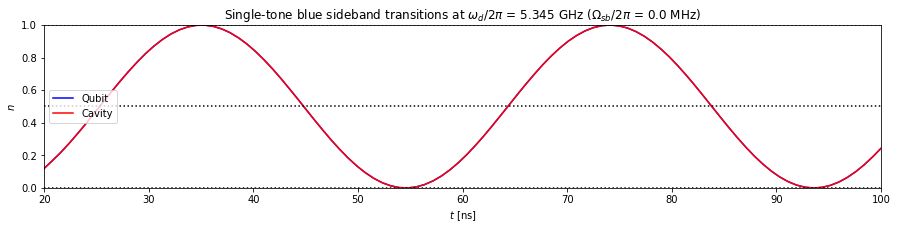

In [10]:
# Plot expectation values
xlim = None  # range of horizontal axis
ylim = None  # range of vertical axis
figsize = [15,3]

if sb == 'red':
    if Nt == 1:
        figqc = sb_expect(times, expect, sb, Nt, H_args, coupling, xlim=xlim, ylim=ylim, figsize=figsize,
                          wsb=wsb, Omega=Omega, wd=wd)
    elif Nt == 2:
        figqc = sb_expect(times, expect, sb, Nt, H_args, coupling, xlim=xlim, ylim=ylim, figsize=figsize,
                          wsb=wsb, Omegaq=Omegaq, Omegac=Omegac)
elif sb == 'blue':
    if Nt == 1:
        figqc = sb_expect(times, expect, sb, Nt, H_args, coupling, xlim=xlim, ylim=ylim, figsize=figsize,
                          wsb=wsb, Omega=Omega, wd=wd)
    elif Nt == 2:
        figqc = sb_expect(times, expect, sb, Nt, H_args, coupling, xlim=xlim, ylim=ylim, figsize=figsize,
                          wsb=wsb, Omegaq=Omegaq, Omegac=Omegac)

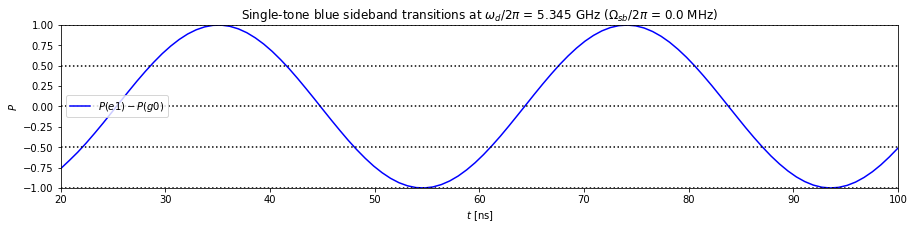

In [11]:
# Plot combined probabilities
xlim = None  # range of horizontal axis
ylim = None  # range of vertical axis
figsize = [15,3]

if sb == 'red':
    if Nt == 1:
        fig = sb_combined_probs(times, sb, Nt, H_args, coupling, xlim=xlim, ylim=xlim, figsize=figsize,
                                e0=e0, g1=g1, wd=wd, wsb=wsb, Omega=Omega)
    elif Nt == 2:
        fig = sb_combined_probs(times, sb, Nt, H_args, coupling, xlim=xlim, ylim=xlim, figsize=figsize,
                                e0=e0, g1=g1, wsb=wsb, Omegaq=Omegaq, Omegac=Omegac)
elif sb == 'blue':
    if Nt == 1:
        fig = sb_combined_probs(times, sb, Nt, H_args, coupling, xlim=xlim, ylim=xlim, figsize=figsize,
                                e1=e1, g0=g0, wd=wd, wsb=wsb, Omega=Omega)
    elif Nt == 2:
        fig = sb_combined_probs(times, sb, Nt, H_args, coupling, xlim=xlim, ylim=xlim, figsize=figsize,
                                e1=e1, g0=g0, wsb=wsb, Omegaq=Omegaq, Omegac=Omegac)

# 5. Save data and plots

In [210]:
# Save all data and plots with a single click on the button!
data_saved = False
data_button = widgets.Button(description='Save data')
data_out = widgets.Output()
def data_clicked(b):
    data_button.description = 'Data saved!'
    with data_out:
        global srcfolder
        
        parfile = open(srcfolder + "/parameters.txt", "a+")
        parfile.write("sideband transition frequency   wsb    : {} = {} GHz\n".format(wsb, wsb/2/pi))
        parfile.write("sideband transition coupling    gsb    : {} = {} GHz".format(wsb/2, wsb/2/2/pi))
        parfile.close()
                
        if Nt == 1:
            new_folder_name = home + "data/data_{}_{}_Nq{}_Nt{}_Om{}_wd{}_wq{}_wc{}_wsb{}".format(
                              ID, sb, Nq, Nt, round(Omega/2/pi, 2), round(wd/2/pi, 3), round(wq/2/pi, 2),
                              round(wc/2/pi, 2), round(wsb/2/pi, 4))
            figqc.savefig(srcfolder + "/" + "figqc_{}.png".format(ID, bbox_inches='tight'))
            fig.savefig(srcfolder + "/" + "fig_{}.png".format(ID, bbox_inches='tight'))
        elif Nt == 2:
            new_folder_name = home + "data/data_{}_{}_Nq{}_Nt{}_Omq{}_wdq{}_Omc{}_wdc{}_dw{}_wq{}_wc{}_wsb{}".format(
                              ID, sb, Nq, Nt, round(Omegaq/2/pi, 2), round(wdq/2/pi, 3), round(Omegac/2/pi, 2),
                              round(wdc/2/pi, 3), round(dw/2/pi, 1), round(wq/2/pi, 2),
                              round(wc/2/pi, 2), round(wsb/2/pi, 4))
            figqc.savefig(srcfolder + "/" + "figqc_{}.png".format(ID, bbox_inches='tight'))
            fig.savefig(srcfolder + "/" + "fig_{}.png".format(ID, bbox_inches='tight'))
        os.rename(srcfolder, new_folder_name)
        print("Folder renamed to", new_folder_name)
        srcfolder = new_folder_name
data_button.on_click(data_clicked)
widgets.VBox([data_button, data_out])

VBox(children=(Button(description='Save data', style=ButtonStyle()), Output()))

# Scanning

IMPORTANT NOTE: All cells from 1. Parameters (including Autofill) should be run prior to each of the scanning cells below, every single time one of the cells below is run.

## A. Sideband transitions

In [166]:
fshifts = np.linspace(-0.0990*2*pi, -0.1*2*pi, 11)  # qubit frequency shift range to scan
Npool = 6                                       # number of parallel simulations

for progf in glob(home + "temp/prog_*"):
    shutil.rmtree(progf)  # delete all existing progfiles
for figure in glob(home + "temp/fig*"):
    os.remove(figure)  # delete all existing figures
fshifts = zip(range(len(fshifts)), fshifts)
pool = mp.Pool(Npool)
if Nt == 1:
    pool.starmap(sbsample, [(Nq, wq, wc, Ec, g, fshift, sb, Nt, H, H_args, psi0, Np_per_batch, options, home, True,
                             Omega) for fshift in fshifts])
elif Nt == 2:
    pool.starmap(sbsample, [(Nq, wq, wc, Ec, g, fshift, sb, Nt, H, H_args, psi0, Np_per_batch, options, home, True,
                             Omegaq, Omegac, dw) for fshift in fshifts])
pool.close()
for progf in glob(home + "temp/prog_*"):
    shutil.rmtree(progf)  # delete all progfiles
print("Done.")

Done.


## B. Qubit frequency shift

In [20]:
wps = np.linspace(wq-0.018*2*pi, wq-0.019*2*pi, 11)  # probe frequency range to scan
Npool = 6                                       # number of parallel simulations
drive_on = True

for progf in glob(home + "temp/prog_*"):
    shutil.rmtree(progf)  # delete all existing progfiles
for figure in glob(home + "temp/fig*"):
    os.remove(figure)  # delete all existing figures
wps = zip(range(len(wps)), wps)
pool = mp.Pool(Npool)
b, nq = ops(Nq)
Hq = wqb*nq -Ec/12*(b + b.dag())**4            # qubit intrinsic
Omegap = 0.005  # amplitude of probe tone
Hp = Omegap*(b + b.dag())
if Nt == 1:
    Hd = Omega*(b + b.dag())  # single-tone drive
    H = [Hq, [Hd, drive], [Hp, probe]]  # complete Hamiltonian
elif Nt == 2:
    Hdq = Omegaq*(b + b.dag())  # double-tone qubit-friendly drive
    Hdc = Omegac*(b + b.dag())  # double-tone cavity-friendly drive
    H = [Hq, [Hdq, driveq], [Hdc, drivec], [Hp, probe]]  # complete Hamiltonian
if not drive_on:
    H = [Hq, [Hp, probe]]  # complete Hamiltonian
psi0 = basis(Nq, 0)
pool.starmap(qfs, [(Nq, wq, Ec, wp, H, H_args, psi0, Nc, Np, Np_per_batch, options, home, True)
                   for wp in wps])
pool.close()
for progf in glob(home + "temp/prog_*"):
    shutil.rmtree(progf)  # delete all progfiles
print("Done.")

Done.


## C. Cavity frequency shift

In [27]:
wps = np.linspace(wc-0.01*2*pi, wc+0.01*2*pi, 21)  # probe frequency range to scan
Npool = 6                                       # number of parallel simulations
drive_on = True

for progf in glob(home + "temp/prog_*"):
    shutil.rmtree(progf)  # delete all existing progfiles
for figure in glob(home + "temp/fig*"):
    os.remove(figure)  # delete all existing figures
wps = zip(range(len(wps)), wps)
pool = mp.Pool(Npool)
Omegap = 0.005  # amplitude of probe tone
Hp = Omegap*(b + b.dag())
if Nt == 1:
    H = [Hjc, [Hc, drive_nonosc], [Hd, drive], [Hp, probe]]  # complete Hamiltonian
elif Nt == 2:
    H = [Hjc, [Hc, drive_nonosc], [Hdq, driveq], [Hdc, drivec], [Hp, probe]]  # complete Hamiltonian
if not drive_on:
    H = [Hjc, [Hp, probe]]  # complete Hamiltonian
psi0 = tensor(basis(Nq, 0), basis(Nc, 0))  # initial state
pool.starmap(cfs, [(Nq, Nc, wc, Ec, wp, H, H_args, psi0, Np_per_batch, options, home, True)
                               for wp in wps])
pool.close()
for progf in glob(home + "temp/prog_*"):
    shutil.rmtree(progf)  # delete all progfiles
print("Done.")

Done.
